In [21]:
import json
import os
import chardet

def load_and_extract_data(file_path):
    try:
        try:
            # 먼저 utf-8 인코딩으로 파일을 열어봅니다.
            with open(file_path, 'r', encoding='utf-8') as file:
                data_dict = json.load(file)
        except UnicodeDecodeError:
            # utf-8로 파일을 열 때 UnicodeDecodeError가 발생하면,
            # chardet을 사용하여 파일 인코딩을 감지합니다.
            with open(file_path, 'rb') as file:
                raw_data = file.read()
                encoding = chardet.detect(raw_data)['encoding']
                if encoding is None:
                    # 인코딩을 결정할 수 없는 경우, 파일 처리를 건너뜁니다.
                    print(f"Unable to determine encoding for {file_path}. Skipping file.")
                    return None, None, None
                data_dict = json.loads(raw_data.decode(encoding))
        
        # 데이터 추출 로직
        category = data_dict['metadata'].get('category', 'No_category').split(" > ")[-1]
        topic = data_dict['document'][0]['metadata'].get('topic', 'No_topic')
        forms_list = data_dict['document'][0].get('utterance', [])
        forms = ' '.join([utterance.get('form', 'No_form') for utterance in forms_list])
        return category, topic, forms
    except FileNotFoundError:
        print(f"Error: The file {file_path} does not exist.")
        return None, None, None
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {file_path}.")
        return None, None, None

# 폴더 경로 설정
folder_path = 'Raw_data_sample'

# 결과를 저장할 딕셔너리
results = {}

# 폴더 내의 모든 파일에 대해 함수 실행
for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        category, topic, forms = load_and_extract_data(file_path)
        if category and topic and forms:
            # 파일명을 키로, 추출된 정보를 값으로 저장
            results[file] = {
                'Category': category,
                'Topic': topic,
                'Forms': forms
            }

# 저장된 결과 중 상위 3개 항목만 출력
for i, (file, info) in enumerate(results.items()):
    if i < 3:  # 상위 3개 항목에 대해서만 작업 수행
        print(f"File: {file}")
        print(f"Category: {info['Category']}")
        print(f"Topic: {info['Topic']}")
        print(f"Forms: {info['Forms']}")
        print('---------------------------')


File: SARW1800000001.json
Category: 뉴스
Topic: 커피 위의 예술, 크리마트에 대한 기사
Forms: 요즘처럼 추운 날씨에는 따뜻한 라테 한잔 찾는 분들 많으실 텐데요. 라테 위에 그려진 다양한 라테 아트를 구경하는 것도 또 다른 재미입니다. 그런데 최근에는 라테아트를 넘어 차가운 커피 위에 색색의 크림으로 그림을 그리는 크리마트가 인기라고 하는데요 이 크리마트를 개발한 바리스타 청년을 오늘 꿈을 잡아라에서 소개합니다. 커피 중에서도 부드러운 라테는 우유와의 궁합을 자랑하는 대표적 겨울 음룐데요 특히 라테 위에 그려지는 라테아트는 눈으로 먼저 즐거움을 선사해줍니다. 최근에는 가장 기본이 되는 그림인 로제타와 하트 외에도 글씨 쓰기 각종 과일이나 빵을 올려 꾸미기까지 다양한 응용 아트가 등장하고 있는데요 그 중심에는 커피와 하얀 우유만으로 그림을 그리는 라테아트를 넘어 형형색색 크림으로 그림을 그리는 크리마트가 있습니다. 어~ 크리마트는 일단 라테아트처럼 스킬이나 기술의 이름이 아니고요 하나의 메뉴의 이름으로서 우선은 따뜻한 거라고 생각을 많이 하시는 분들이 많은데 무조건 차갑게만 만들고 커피를 포함한 차가운 음료 위에 그 위에 크림을 올리고 크림 위에 그림을 그려서 하나의 예술성을 띄우는 그런 제가 만든 창작 메뉴라고 생각을 하시면 될 것 같습니다. 크리마트는 나만의 메뉴 개발에 몰두하던 이강빈 바리스타가 지난 이천십사 년 개발한 메뉸데요. 그는 본인의 실력을 뽐내는 기술을 개발하기보다 소비자에게 특별한 추억과 감동을 줄 수 있는 메뉴를 만들고 싶었다고 말합니다. 어~ 많이들 이제 고민을 하시는 부분이에요 자기가 이런 커피를 뭐 만드는데 소비자들은 몰라주는 것 같다. 전문가라면 그 사람들한테 내가 잘하는 커피를 무조건 강요할라고 하는 게 아니라 그 사람들이 원하는 커피를 최선의 상태에서 잘 맞춰서 제공할 수 있는 게 제가 생각하는 좋은 바리스타라고 생각을 하거든요 수많은 시행착오 끝에 완성된 크리마트는 이제 국내를 넘어 보라카이

### Mecab 데이터 토크나이징

In [22]:
from mecab import MeCab
mecab = MeCab()

In [23]:
from tqdm.notebook import tqdm

def divide_into_batches(data, batch_size):
    """데이터를 주어진 배치 크기로 나누어 리스트로 반환합니다."""
    items = list(data.items())
    return [dict(items[i:i + batch_size]) for i in range(0, len(items), batch_size)]

def process_batch(batch):
    """배치 처리 로직을 구현합니다. 원본 데이터는 유지하고, 태깅된 정보만 새로운 딕셔너리에 저장합니다."""
    processed_batch = {}
    for file, info in batch.items():
        # 새로운 딕셔너리에 태깅된 데이터 저장
        processed_info = {
            'TaggedCategory': ['{}/{}'.format(word, tag) for word, tag in mecab.pos(info['Category'])],
            'TaggedTopic': ['{}/{}'.format(word, tag) for word, tag in mecab.pos(info['Topic'])],
            'TaggedForms': ['{}/{}'.format(word, tag) for word, tag in mecab.pos(info['Forms'])]
        }
        processed_batch[file] = processed_info
    
    return processed_batch

# 메인 로직
if __name__ == "__main__":
    batch_size = 10  # 배치 크기 설정
    batches = divide_into_batches(results, batch_size)
    processed_results = {}

    for batch in tqdm(batches):
        processed_batch = process_batch(batch)
        processed_results.update(processed_batch)

    # 변경된 results 딕셔너리 확인 (처리 진행 상황 표시 후)
    for i, (file, info) in enumerate(processed_results.items()):
        if i < 3:  # 상위 3개 항목에 대해서만 작업 수행
            print(f"File: {file}")
            print(f"TaggedCategory: {info['TaggedCategory']}")
            print(f"TaggedTopic: {info['TaggedTopic']}")
            print(f"TaggedForms: {info['TaggedForms'][:5]}...")  # 태그된 본문의 일부만 출력
            print('---------------------------')


  0%|          | 0/340 [00:00<?, ?it/s]

File: SARW1800000001.json
TaggedCategory: ['뉴스/NNG']
TaggedTopic: ['커피/NNG', '위/NNG', '의/JKG', '예술/NNG', ',/SC', '크리/NNP', '마트/NNG', '에/JKB', '대한/VV+ETM', '기사/NNG']
TaggedForms: ['요즘/NNG', '처럼/JKB', '추운/VA+ETM', '날씨/NNG', '에/JKB']...
---------------------------
File: SARW1800000002.json
TaggedCategory: ['뉴스/NNG']
TaggedTopic: ['도서관/NNG', '의/JKG', '변신/NNG', ',/SC', '메이커/NNG', '스페이스/NNG', '에/JKB', '대한/VV+ETM', '기사/NNG']
TaggedForms: ['미국/NNP', '의/JKG', '공공/NNG', '도서관/NNG', '들/XSN']...
---------------------------
File: SARW1800000003.json
TaggedCategory: ['뉴스/NNG']
TaggedTopic: ['덕/NNG', '질/XSN', '로/JKB', '행복/NNG', '한/XSA+ETM', '학교/NNG', '생활/NNG', '에/JKB', '대한/VV+ETM', '기사/NNG']
TaggedForms: ['특정/NNG', '한/XSA+ETM', '무언가/NP+VCP+EC', '에/JKB', '푹/MAG']...
---------------------------


In [26]:
import pickle

# processed_results 딕셔너리를 파일로 저장하기
with open('processed_results_sample.pickle', 'wb') as handle:
    pickle.dump(processed_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import pickle
# 파일로부터 results 딕셔너리 로드하기
with open('processed_results_sample.pickle', 'rb') as handle:
    loaded_results = pickle.load(handle)
results = loaded_results
results_list = [(file, info) for file, info in processed_results.items()]   
# 로드된 딕셔너리 확인
for i, (file, info) in enumerate(loaded_results.items()):
    if i < 3:  # 상위 3개 항목에 대해서만 작업 수행
        print(f"File: {file}")
        print(f"TaggedCategory: {info['TaggedCategory']}")
        print(f"TaggedTopic: {info['TaggedTopic']}")
        print(f"TaggedForms: {info['TaggedForms'][:5]}...")  # 태그된 본문의 일부만 출력
        print('---------------------------')


### DBOW (Doc2Vec) 모델 학습

In [29]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# TaggedDocument 객체 생성
# 'TaggedForms'에서 각 문서의 형태소 분석 및 품사 태깅된 결과를 사용합니다.
tagged_documents = [
    TaggedDocument(words=info['TaggedForms'], tags=[file])
    for file, info in processed_results.items()
]

# 모델 학습
model_dbow = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, dm=0, epochs=20)
model_dbow.build_vocab(tagged_documents)
model_dbow.train(tagged_documents, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

# 모델 저장 (선택사항)
model_dbow.save("model_dbow.doc2vec")

In [30]:
# 사용자 입력에 대한 형태소 분석 및 품사 태깅
input_text = "커피 한 잔이 많은 이들에게 따뜻한 위안이 되고 있습니다."
tagged_input_text = ['{}/{}'.format(word, tag) for word, tag in mecab.pos(input_text)]

# 형태소 분석 및 품사 태깅 결과 확인
print("태그된 입력 텍스트:", tagged_input_text)

# Doc2Vec 모델을 사용하여 입력 텍스트 벡터를 추론
input_vector = model_dbow.infer_vector(tagged_input_text)

# 추론된 벡터를 사용하여 가장 유사한 문서 찾기
similar_docs = model_dbow.dv.most_similar([input_vector], topn=5)

# 가장 유사한 문서 출력
print("가장 유사한 문서:", similar_docs)

태그된 입력 텍스트: ['커피/NNG', '한/MM', '잔/NNG', '이/JKS', '많/VA', '은/ETM', '이/NP', '들/XSN', '에게/JKB', '따뜻/XR', '한/XSA+ETM', '위안/NNG', '이/JKS', '되/VV', '고/EC', '있/VX', '습니다/EF', './SF']
가장 유사한 문서: [('SARW1800000924.json', 0.6430445313453674), ('SARW1800001121.json', 0.6236328482627869), ('SARW1900000163.json', 0.621150016784668), ('SARW1800001030.json', 0.6182907819747925), ('SARW1800000626.json', 0.6177394986152649)]


In [31]:
# 학습된 Doc2Vec 모델 로드 (필요한 경우)
model_dbow = Doc2Vec.load("model_dbow.doc2vec")

# 문서 벡터 추출
doc_vectors = [model_dbow.dv[tag] for tag in model_dbow.dv.key_to_index.keys()]

# 추출된 문서 벡터 중 일부 확인 (예: 첫 번째 문서 벡터)
print(doc_vectors[0])


[-0.47939515 -0.38695446 -0.14498158 -0.10790221 -0.24502034  0.4833333
 -0.30569923 -1.6414278   0.14856291  0.16911086  0.43470088  0.9060785
  0.19665912 -0.24595425  0.26579073  0.4748689  -0.07001638 -0.16486257
 -0.21919584 -0.12563282  0.17627275  0.36221972  0.11003363  0.612008
  0.58215743  0.16732648 -0.6288002  -0.6886506   0.04927369 -0.6286451
  0.81245446 -0.6813592  -0.13599585  0.9157314   0.76755106 -0.9263929
  0.77863556 -0.10750007 -0.77462435  0.43669733  0.11417157 -0.12748739
 -0.12807153 -0.42050934  0.2105749  -0.2957667  -0.02984566 -0.94757843
  0.19766536 -1.2280498  -0.93855935  0.31575367 -0.5223812  -0.6801943
 -0.03334758 -0.3763441   0.9396485   0.1363816  -0.53621936  0.40126085
 -0.33282235  0.9594107   0.87952834  0.6885803  -0.7960043   0.04433962
  0.54658717 -0.5015886  -0.2380489   0.7594376   0.438742    0.05376922
 -0.59070307 -1.2656037  -0.2955897  -0.4360342   0.6726818   0.25111032
 -0.3081391  -0.29727563  0.0068692  -0.1336623  -0.634603

In [52]:
from sklearn.manifold import TSNE
import numpy as np

# 벡터를 NumPy 배열로 변환 (Word2Vec 또는 Doc2Vec 벡터를 사용)
vectors = np.array(doc_vectors)  # doc_vectors 또는 word_vectors

# t-SNE를 사용한 차원 축소
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(vectors)

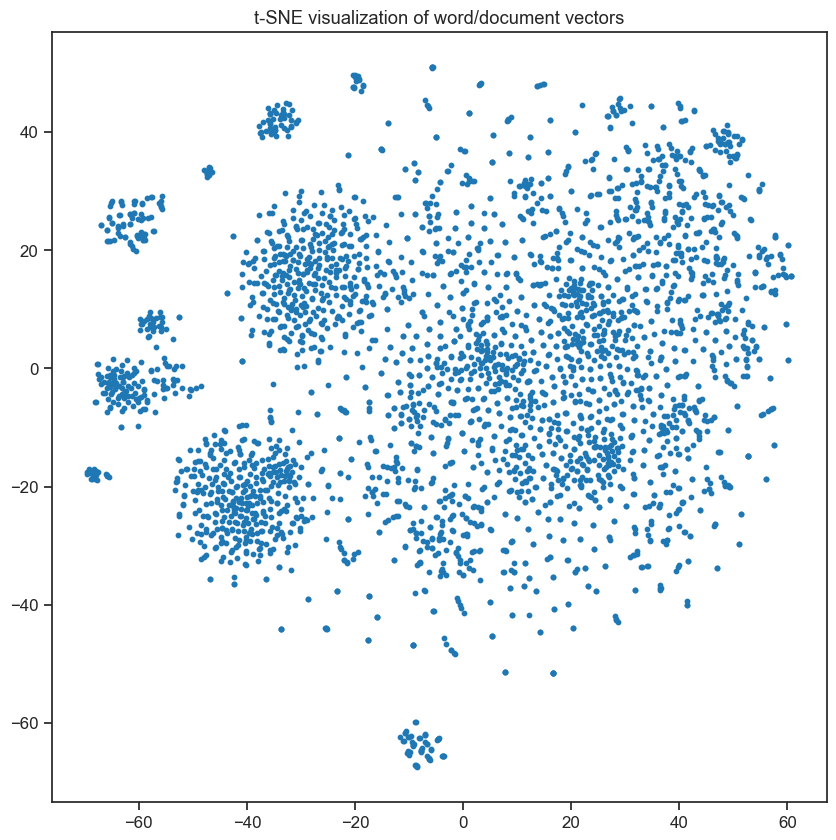

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# 2차원 벡터 플롯
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=10)  # s는 마커의 크기

# # 필요한 경우, 특정 문서에 라벨을 추가
# for i, word in enumerate(['SARW1800000001.json', 'SARW180000002']):  # 사용할 단어나 문서 ID
#     plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("t-SNE visualization of word/document vectors")
plt.show()

### Skip-gram Word2Vec 모델 학습

In [42]:
from gensim.models import Word2Vec

# Skip-gram 모델 학습을 위한 입력 데이터 준비
# 'TaggedForms'에서 각 문서의 형태소 분석 및 품사 태깅된 결과를 사용합니다.
sentences = [info['TaggedForms'] for _, info in processed_results.items()]

# Skip-gram 모델 학습 (sg=1 설정으로 Skip-gram 선택)
model_skipgram = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1, epochs=20)

# 모델 저장 (선택사항)
model_skipgram.save("model_skipgram.word2vec")


In [43]:
#단어 유사도
example_word = "학교"
tagged_example_word = ['{}/{}'.format(word, tag) for word, tag in mecab.pos(example_word)]

print("태그된 예시 단어:", tagged_example_word)

# 주의: 이 코드는 태그된 단어가 모델의 어휘에 포함되어 있어야 작동합니다.
try:
    similar_words = model_skipgram.wv.most_similar(tagged_example_word, topn=5)
    print("가장 유사한 단어:", similar_words)
except KeyError as e:
    print("오류:", e)

태그된 예시 단어: ['학교/NNG']
가장 유사한 단어: [('초등/NNG', 0.8568859696388245), ('중학교/NNG', 0.8102878332138062), ('고등학교/NNG', 0.7724533677101135), ('교실/NNG', 0.7491936683654785), ('교사/NNG', 0.7342767119407654)]


In [63]:
# Word2Vec 모델 로드
model_sg = Word2Vec.load("model_skipgram.word2vec")

# 단어 벡터 추출
word_vectors = np.array([model_sg.wv[word] for word in model_sg.wv.index_to_key])

# 추출된 문서 벡터 중 일부 확인 (예: 첫 번째 문서 벡터)
print(doc_vectors[0])

[-0.47939515 -0.38695446 -0.14498158 -0.10790221 -0.24502034  0.4833333
 -0.30569923 -1.6414278   0.14856291  0.16911086  0.43470088  0.9060785
  0.19665912 -0.24595425  0.26579073  0.4748689  -0.07001638 -0.16486257
 -0.21919584 -0.12563282  0.17627275  0.36221972  0.11003363  0.612008
  0.58215743  0.16732648 -0.6288002  -0.6886506   0.04927369 -0.6286451
  0.81245446 -0.6813592  -0.13599585  0.9157314   0.76755106 -0.9263929
  0.77863556 -0.10750007 -0.77462435  0.43669733  0.11417157 -0.12748739
 -0.12807153 -0.42050934  0.2105749  -0.2957667  -0.02984566 -0.94757843
  0.19766536 -1.2280498  -0.93855935  0.31575367 -0.5223812  -0.6801943
 -0.03334758 -0.3763441   0.9396485   0.1363816  -0.53621936  0.40126085
 -0.33282235  0.9594107   0.87952834  0.6885803  -0.7960043   0.04433962
  0.54658717 -0.5015886  -0.2380489   0.7594376   0.438742    0.05376922
 -0.59070307 -1.2656037  -0.2955897  -0.4360342   0.6726818   0.25111032
 -0.3081391  -0.29727563  0.0068692  -0.1336623  -0.634603

In [64]:
# t-SNE를 사용한 차원 축소
tsne = TSNE(n_components=2, random_state=0)
vectors_2d = tsne.fit_transform(word_vectors)

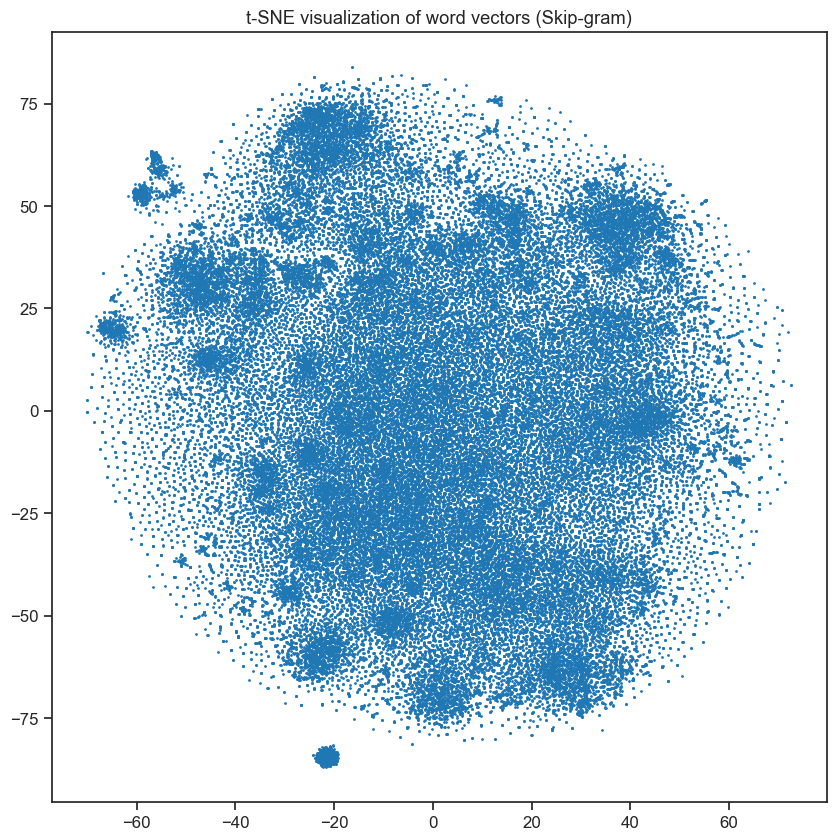

In [66]:
# 시각화 설정
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# 2차원 벡터 플롯
plt.figure(figsize=(10, 10))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], s=1)  # s는 마커의 크기

# # 필요한 경우, 특정 단어에 라벨을 추가
# for i, word in enumerate(['example_word1', 'example_word2']):  # 사용할 단어
#     plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("t-SNE visualization of word vectors (Skip-gram)")
plt.show()